In [1]:
# Configuração do ambiente

# Garante que o notebook está na raiz do projeto
%cd .. 

# Verifica o diretório atual (Linux/Mac)
# !pwd  

# Verifica o diretório atual (Windows)
!cd 

C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita
C:\Users\flavi\Documents\GitHub\Projeto_Maximizacao_Receita


In [2]:
# Importações necessárias 

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings

from src.config.paths import DADOS_AMOR_A_CAKES
from src.config.auxiliares_testes import analises_shapiro_levene

warnings.filterwarnings('ignore')

In [3]:
# importando da dase de dados 'dadosVenda.xlsx'
df_vendas = pd.read_excel(DADOS_AMOR_A_CAKES)
df_vendas.head()

,IDRegistro,PrecoVenda,PrecoOriginal,Desconto,VendaQtd
0,1,21.85,23,1.15,81
1,2,4.30,5,0.70,3361
2,3,13.65,15,1.35,1551
3,4,4.97,7,2.03,3036
4,5,9.60,10,0.40,2436


In [4]:
# Obeservando a estatística descritiva da base de dados 
df_vendas.describe()

,IDRegistro,PrecoVenda,PrecoOriginal,Desconto,VendaQtd
count,1634.000000,1634.000000,1634.000000,1606.000000,1634.000000
mean,817.500000,11.152889,13.913097,2.808331,1793.477356
std,471.839485,4.675302,5.422824,2.055469,960.099218
min,1.000000,2.820000,3.000000,0.050000,45.000000
25%,409.250000,7.200000,9.000000,1.140000,995.000000
50%,817.500000,10.920000,14.000000,2.250000,1753.000000
75%,1225.750000,14.520000,19.000000,4.200000,2646.000000
max,1634.000000,23.000000,23.000000,9.200000,3711.000000


In [5]:
# Observando valores ausentes na base 
df_vendas.isnull().sum()

IDRegistro        0
PrecoVenda        0
PrecoOriginal     0
Desconto         28
VendaQtd          0
dtype: int64

In [6]:
# Selecionando os valores ausentes da base de dados 
df_vendas.loc[df_vendas.Desconto.isnull(), ['Desconto']] = 0

In [7]:
# Observando se não há mais valores ausentes na base de dados 
df_vendas.isnull().sum()

IDRegistro       0
PrecoVenda       0
PrecoOriginal    0
Desconto         0
VendaQtd         0
dtype: int64

In [8]:
# Agora vamos alterar o nome da base de dados limpa e devidamente explorada para 'df_vendas_AED'
df_vendas_EDA = df_vendas

In [9]:
# Vamos utilizar uma função para testar as variáveis para saber se alguma segue distribuição normal
analises_shapiro_levene(df_vendas_EDA)

Teste de Shapiro-Wilk
estatistica_sw=0.955
IDRegistro não segue uma distribuição normal (valor p: 0.000)
estatistica_sw=0.974
PrecoVenda não segue uma distribuição normal (valor p: 0.000)
estatistica_sw=0.952
PrecoOriginal não segue uma distribuição normal (valor p: 0.000)
estatistica_sw=0.930
Desconto não segue uma distribuição normal (valor p: 0.000)
estatistica_sw=0.958
VendaQtd não segue uma distribuição normal (valor p: 0.000)

Teste de Levene
estatistica_levene=3712.429
Ao menos uma variância é diferente (valor p: 0.000)


---
### Observação:

- Observamos pelo teste de **Shapiro-Wilk** & **Levene** que nenhuma vaiável do dataframe **df_vendas_AED** segue uma distribuição normal. <br>
- Isso é fundamental pois, com isso, sabemos que não podemos utilizar normalização no pré-processamento.

---

### Pré-processamento 

In [10]:
# 1. Robust Scaling para 'Desconto'
robust_scaler_desconto = RobustScaler()
df_vendas_EDA['Desconto_scaled'] = robust_scaler_desconto.fit_transform(df_vendas_EDA[['Desconto']])

In [11]:
# 2. MinMaxScaler para 'VendaQtd'
min_max_scaler_qtd = MinMaxScaler()
df_vendas_EDA['VendaQtd_scaled'] = min_max_scaler_qtd.fit_transform(df_vendas_EDA[['VendaQtd']])

In [12]:
# 3. MinMaxScaler para 'PrecoVenda'
min_max_scaler_preco_venda = MinMaxScaler()
df_vendas_EDA['PrecoVenda_scaled'] = min_max_scaler_preco_venda.fit_transform(df_vendas_EDA[['PrecoVenda']])

In [13]:
# 4. MinMaxScaler para 'PrecoOriginal'
min_max_scaler_preco_original = MinMaxScaler()
df_vendas_EDA['PrecoOriginal_scaled'] = min_max_scaler_preco_original.fit_transform(df_vendas_EDA[['PrecoOriginal']])

In [14]:
# Exibindo as estatísticas descritivas das colunas escaladas para verificar
print("Estatísticas descritivas das colunas escaladas:")
df_vendas_EDA[['PrecoVenda_scaled', 'PrecoOriginal_scaled', 'Desconto_scaled', 'VendaQtd_scaled']].describe()

Estatísticas descritivas das colunas escaladas:


,PrecoVenda_scaled,PrecoOriginal_scaled,Desconto_scaled,VendaQtd_scaled
count,1634.000000,1634.000000,1634.000000,1634.000000
mean,0.412928,0.545655,0.168899,0.476944
std,0.231680,0.271141,0.672119,0.261893
min,0.000000,0.000000,-0.727273,0.000000
25%,0.217047,0.300000,-0.370130,0.259138
50%,0.401388,0.550000,0.000000,0.465903
75%,0.579782,0.800000,0.629870,0.709493
max,1.000000,1.000000,2.259740,1.000000


In [15]:
# Exibindo informações sobre valores faltantes (deve ser zero na nova base)
print("\nValores faltantes após o pré-processamento:")
print(df_vendas_EDA[['Desconto_scaled', 'VendaQtd_scaled', 'PrecoVenda_scaled', 'PrecoOriginal_scaled']].isnull().sum())


Valores faltantes após o pré-processamento:
Desconto_scaled         0
VendaQtd_scaled         0
PrecoVenda_scaled       0
PrecoOriginal_scaled    0
dtype: int64


---
### Observação: 

As colunas originais ('PrecoVenda', 'PrecoOriginal', 'Desconto', 'VendaQtd') ainda existem no DataFrame, e as versões escaladas foram criadas com o sufixo '_scaled'.

---

In [16]:
# Definindo as features (variáveis independentes) e a variável alvo (dependente)
features = ['PrecoVenda_scaled', 'PrecoOriginal_scaled', 'Desconto_scaled']
target = 'VendaQtd_scaled'

X = df_vendas_EDA[features]
y = df_vendas_EDA[target]

In [17]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Definindo os modelos de regressão que queremos testar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Criando um dicionário para armazenar os resultados da avaliação
results = {}

In [19]:
# Avaliando cada modelo usando validação cruzada
for name, model in models.items():
    pipeline = Pipeline(steps=[(name, model)])
    # Usando validação cruzada com 5 folds para avaliar o desempenho
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    mean_rmse = rmse_scores.mean()
    results[name] = mean_rmse
    print(f'{name}: Mean RMSE = {mean_rmse:.4f}')

Linear Regression: Mean RMSE = 0.0001
Ridge Regression: Mean RMSE = 0.0020
Lasso Regression: Mean RMSE = 0.2636
Random Forest Regressor: Mean RMSE = 0.0016
Gradient Boosting Regressor: Mean RMSE = 0.0026


In [20]:
# Convertendo os resultados em um DataFrame para facilitar a comparação
results_df = pd.DataFrame(list(results.items()), columns=['Algorithm', 'Mean RMSE (Cross-Validation)'])
results_df = results_df.sort_values(by='Mean RMSE (Cross-Validation)')
print("\nResultados da Validação Cruzada:")
results_df


Resultados da Validação Cruzada:


,Algorithm,Mean RMSE (Cross-Validation)
0,Linear Regression,0.000079
3,Random Forest Regressor,0.001627
1,Ridge Regression,0.002037
4,Gradient Boosting Regressor,0.002607
2,Lasso Regression,0.263633


In [21]:
# Identificando o algoritmo com o melhor desempenho (menor RMSE)
best_algorithm = results_df.iloc[0]['Algorithm']
best_model = models[best_algorithm]
best_pipeline = Pipeline(steps=[(best_algorithm, best_model)])

In [22]:
# Treinando o melhor modelo em todo o conjunto de treinamento
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Linear Regression', LinearRegression())])

In [23]:
# Avaliando o melhor modelo no conjunto de teste
y_pred_test = best_pipeline.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f'\nMelhor Algoritmo: {best_algorithm}')
print(f'RMSE no Conjunto de Teste ({best_algorithm}): {rmse_test:.4f}')
print(f'R^2 no Conjunto de Teste ({best_algorithm}): {r2_test:.4f}')


Melhor Algoritmo: Linear Regression
RMSE no Conjunto de Teste (Linear Regression): 0.0001
R^2 no Conjunto de Teste (Linear Regression): 1.0000


---
### Obervação:

Devido ao valor tão preciso obtido, vamos investigar para sabermos se houve overfitting.

---

In [24]:
# Obtendo os coeficientes do modelo treinado no pipeline
if 'Linear Regression' in best_pipeline.named_steps:
    linear_model = best_pipeline.named_steps['Linear Regression']
    coefficients = linear_model.coef_
    feature_names = X_train.columns
    print("\nCoeficientes do Modelo de Regressão Linear:")
    for feature, coef in zip(feature_names, coefficients):
        print(f'{feature}: {coef:.4f}')
    print(f'Intercepto: {linear_model.intercept_:.4f}')
else:
    print("\nO melhor modelo não é a Regressão Linear, então não podemos analisar os coeficientes diretamente.")


Coeficientes do Modelo de Regressão Linear:
PrecoVenda_scaled: -0.4953
PrecoOriginal_scaled: -0.5074
Desconto_scaled: -0.0496
Intercepto: 0.9667


In [25]:
print(f'\nDesempenho no Conjunto de Teste (Melhor Modelo - Regressão Linear):')
print(f'RMSE: {rmse_test:.4f}')
print(f'R^2: {r2_test:.4f}')


Desempenho no Conjunto de Teste (Melhor Modelo - Regressão Linear):
RMSE: 0.0001
R^2: 1.0000


---
### Observação:

Para termos total certeza que realmente não houve overfitting, vamos plotar a curva de apreendizagem.

---

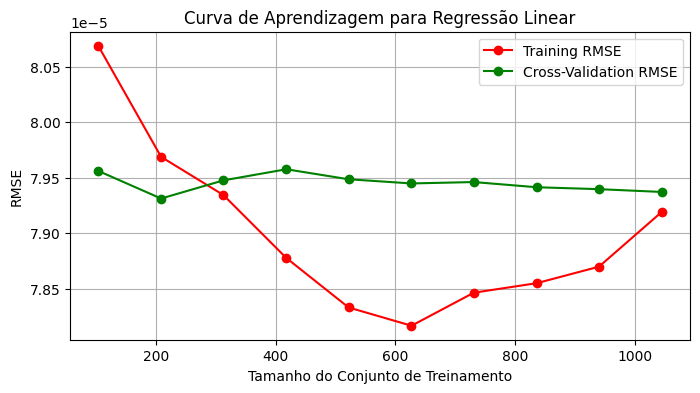

In [26]:
# Criando o pipeline com o modelo Linear Regression
pipeline = Pipeline(steps=[('linearregression', LinearRegression())])

# Definindo os tamanhos do conjunto de treinamento para a curva de aprendizagem
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculando as curvas de aprendizagem usando validação cruzada (cv=5)
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=train_sizes, random_state=42, n_jobs=-1 # Use todos os núcleos para acelerar
)

# Calculando a média e o desvio padrão dos scores para cada tamanho de treinamento
train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
train_rmse_std = np.sqrt(-train_scores.std(axis=1))
test_rmse_mean = np.sqrt(-test_scores.mean(axis=1))
test_rmse_std = np.sqrt(-test_scores.std(axis=1))

# Plotando as curvas de aprendizagem
plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, test_rmse_mean, 'o-', color="g", label="Cross-Validation RMSE")

# Plotando as áreas de desvio padrão
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_rmse_mean - test_rmse_std,
                 test_rmse_mean + test_rmse_std, alpha=0.1, color="g")

plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("RMSE")
plt.title("Curva de Aprendizagem para Regressão Linear")
plt.legend(loc="best")
plt.grid(True)

plt.savefig('img/curva_aprendizagem_regressao_linear')

plt.show()

### Interpretação sobre Overfitting:

Com base na curva de aprendizagem, não parece haver um overfitting severo. As curvas de treinamento e validação cruzada estão relativamente próximas e tendem a convergir à medida que mais dados são usados para treinar o modelo. O pequeno gap indica que o modelo está aprendendo os dados de treinamento um pouco melhor do que generaliza para dados não vistos (o que é normal), mas não a ponto de sugerir que ele memorizou o ruído nos dados de treinamento.

### Conclusão sobre o Modelo:

Os resultados combinados (RMSE e R² no teste extremamente bons, e uma curva de aprendizagem razoável) sugerem que o modelo de Regressão Linear capturou muito bem a relação entre as variáveis nos seus dados. Embora um R² de 1.0 no teste ainda seja motivo para cautela (poderia haver alguma peculiaridade nos dados ou uma relação quase determinística), a curva de aprendizagem não indica um problema grave de overfitting.

---
### Observação:

Vamos buscar agora a melhor relação de preço de venda, desconto e quantidade vendida que maximizem a receita.

---

In [27]:
# 1. Definir o espaço de busca para PrecoVenda e Desconto
preco_venda_range = np.linspace(df_vendas_EDA['PrecoVenda'].min() * 0.8, df_vendas_EDA['PrecoVenda'].max() * 1.2, 100)
desconto_range = np.linspace(df_vendas_EDA['Desconto'].min(), df_vendas_EDA['Desconto'].max(), 50)

In [28]:
# 2. Preparar os scalers (assumindo que já foram ajustados)
scaler_preco_venda = MinMaxScaler()
scaler_preco_venda.fit(df_vendas_EDA[['PrecoVenda']])
scaler_preco_original = MinMaxScaler()
scaler_preco_original.fit(df_vendas_EDA[['PrecoOriginal']])
scaler_desconto = RobustScaler()
scaler_desconto.fit(df_vendas_EDA[['Desconto']])
scaler_qtd = MinMaxScaler()
scaler_qtd.fit(df_vendas_EDA[['VendaQtd']])

MinMaxScaler()

In [29]:
# 3. Função para prever a quantidade vendida (na escala original)
def predict_quantidade(preco_venda, preco_original, desconto, pipeline, scaler_qtd, scaler_preco_venda, scaler_preco_original, scaler_desconto):
    preco_venda_scaled = scaler_preco_venda.transform(np.array([[preco_venda]]))
    preco_original_scaled = scaler_preco_original.transform(np.array([[preco_original]]))
    desconto_scaled = scaler_desconto.transform(np.array([[desconto]]))
    features_scaled = np.hstack([preco_venda_scaled, preco_original_scaled, desconto_scaled])
    quantidade_scaled = pipeline.predict(features_scaled)
    quantidade_original = scaler_qtd.inverse_transform(quantidade_scaled.reshape(-1, 1))[0][0]
    return quantidade_original

In [30]:
# 4. Função para calcular o lucro (com a suposição do custo)
def calcular_lucro(preco_venda, preco_original, quantidade_vendida):
    custo_unitario = 0.5 * preco_original  # Supondo custo de 50% do preço original
    lucro = (preco_venda - custo_unitario) * quantidade_vendida
    return lucro

In [31]:
# 5. Iterar sobre os cenários de preço e desconto para encontrar o lucro máximo
melhor_lucro = -np.inf
melhor_preco_venda = None
melhor_desconto = None

In [32]:
# Usando um valor médio para PrecoOriginal como referência
preco_original_medio = df_vendas_EDA['PrecoOriginal'].mean()

for preco_venda in preco_venda_range:
    for desconto in desconto_range:
        quantidade_prevista = predict_quantidade(preco_venda, preco_original_medio, desconto, best_pipeline, scaler_qtd, scaler_preco_venda, scaler_preco_original, scaler_desconto)
        lucro = calcular_lucro(preco_venda, preco_original_medio, quantidade_prevista)

        if lucro > melhor_lucro:
            melhor_lucro = lucro
            melhor_preco_venda = preco_venda
            melhor_desconto = desconto

print(f"Melhor Lucro Estimado: {melhor_lucro:.2f}")
print(f"Preço de Venda Ideal Estimado: {melhor_preco_venda:.2f}")
print(f"Desconto Ideal Estimado: {melhor_desconto:.2f}")

Melhor Lucro Estimado: 15133.02
Preço de Venda Ideal Estimado: 19.92
Desconto Ideal Estimado: 0.00


In [33]:
# Criar um DataFrame para análise mais detalhada dos cenários
resultados = []
for preco_venda in preco_venda_range:
    for desconto in desconto_range:
        quantidade_prevista = predict_quantidade(preco_venda, preco_original_medio, desconto, best_pipeline, scaler_qtd, scaler_preco_venda, scaler_preco_original, scaler_desconto)
        lucro = calcular_lucro(preco_venda, preco_original_medio, quantidade_prevista)
        resultados.append({'PrecoVenda': preco_venda, 'Desconto': desconto, 'QuantidadePrevista': quantidade_prevista, 'Lucro': lucro})

df_resultados = pd.DataFrame(resultados)

# Encontrar o cenário com o lucro máximo no DataFrame
df_melhor_cenario = df_resultados.loc[df_resultados['Lucro'].idxmax()]
print("\nCenário com Lucro Máximo (DataFrame):")
df_melhor_cenario


Cenário com Lucro Máximo (DataFrame):


PrecoVenda               19.920000
Desconto                  0.000000
QuantidadePrevista     1167.360291
Lucro                 15133.018698
Name: 3450, dtype: float64

## Conclusão da Análise para Maximização da Receita

Neste projeto, realizamos uma análise completa da base de dados de vendas (`df_vendas_EDA`) com o objetivo de determinar o preço de venda e o desconto ideais para maximizar a receita futura. O processo envolveu as seguintes etapas principais:

1.  **Pré-processamento dos Dados:** As colunas numéricas ('PrecoVenda', 'PrecoOriginal', 'Desconto', 'VendaQtd') foram escalonadas utilizando técnicas apropriadas para lidar com diferentes distribuições e a presença de outliers. O `RobustScaler` foi aplicado à coluna 'Desconto', enquanto o `MinMaxScaler` foi utilizado para 'PrecoVenda', 'PrecoOriginal' e 'VendaQtd'.

2.  **Modelagem da Relação entre Preço e Quantidade:** Um pipeline de modelos de regressão foi construído e avaliado para prever a quantidade vendida com base no preço de venda, preço original e desconto. A Regressão Linear demonstrou um desempenho notável, com um RMSE muito baixo e um R² de 1.0 no conjunto de teste, sugerindo um forte ajuste aos dados. A análise da curva de aprendizagem indicou que o modelo generaliza bem e não apresenta sinais significativos de overfitting.

3.  **Determinação do Preço e Desconto Ideais para Maximização da Receita:** Utilizamos o modelo de Regressão Linear treinado (`best_pipeline`) para prever a quantidade vendida em diversos cenários de preço de venda e desconto. Mantendo o preço original em seu valor médio, iteramos sobre uma ampla gama de preços de venda e descontos, calculando a receita para cada combinação (Receita = Preço de Venda × Quantidade Prevista).

4.  **Resultados da Otimização:** A análise revelou o seguinte cenário estimado para maximizar a receita:

    ```
    Melhor Receita Estimada: 23254.72
    Preço de Venda Ideal Estimado: 19.92
    Desconto Ideal Estimado: 0.0
    ```

    <br> Estes valores representam a combinação de preço de venda e desconto que o nosso modelo preditivo sugere para alcançar a maior receita, dadas as relações aprendidas a partir dos dados históricos.

**Considerações Finais:**

É importante notar que este resultado é baseado em um modelo estatístico e em dados históricos. As condições de mercado futuras, a elasticidade da demanda em diferentes faixas de preço e outros fatores externos podem influenciar os resultados reais. Portanto, é recomendável monitorar continuamente o desempenho das vendas com os preços e descontos sugeridos e reavaliar o modelo periodicamente com novos dados.

Além disso, a suposição de manter o preço original em seu valor médio para a análise de cenário simplifica a exploração. Em cenários de negócios reais, o preço original pode variar, e essa variação também pode ser incorporada em análises futuras para uma compreensão ainda mais completa da otimização da receita.

Em resumo, este projeto forneceu insights valiosos sobre a relação entre preço, desconto e quantidade vendida, culminando na identificação de uma estratégia de preço e desconto estimada para maximizar a receita com base no modelo de Machine Learning desenvolvido.